In [1]:
import neonutilities as nu
import pandas as pd
import geopandas as gpd
from whitebox import whitebox_tools
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
import laspy
from scipy import spatial
import pickle
import re
from PIL import Image
from datetime import datetime

sns.set_theme()

In [12]:
def get_date_subfolder():
    current_date = datetime.now()
    return current_date.strftime('%Y_%m_%d')

def process_las_files(siteid, site_var, csv_location, crs):
    # Read in icesat coords and reproject to UTM10N
    icesat_coords = pd.read_csv(csv_location)
    icesat_gdf = gpd.GeoDataFrame(icesat_coords, geometry=gpd.points_from_xy(icesat_coords.Longitude, icesat_coords.Latitude),
                                 crs="EPSG:4326")
    icesat_gdf = icesat_gdf.to_crs(crs)
    # is_samples = icesat_gdf.sample(n=20, random_state=2).copy()
    is_samples = icesat_gdf.copy()
    
    las_filelist = glob.glob(f"/data/shared/src/arojas/par_modeling/data/raw/lidar/{siteid}/*.las")
    
    pgap_list = []

    for las_fp in las_filelist:
        print(os.path.basename(las_fp))
        # read in data using laspy
        las = laspy.read(las_fp)
        # get points to perform spatial search
        dataset = np.vstack((las.x, las.y)).transpose()
        tree = spatial.cKDTree(dataset)
        # Go through each icesat point and filter data
        for g_idx in range(len(is_samples)):
            # get individual xy
            icesat_xy = np.array([is_samples.iloc[[g_idx]].geometry.x.values[0], is_samples.iloc[[g_idx]].geometry.y.values[0]])
            spatial_bool = tree.query_ball_point(icesat_xy, r=12.5)
            if len(spatial_bool) == 0:
                continue

            # now run GapDS
            pgap = nu.smfp.GapDS(np.array(las.x[spatial_bool]), 
                                 np.array(las.y[spatial_bool]),
                                 np.array(las.z[spatial_bool]),
                                 las.scan_angle_rank[spatial_bool],
                                 np.array(las.classification[spatial_bool]))
            pgap_list.append((pgap, is_samples.iloc[[g_idx]].index[0]))

    object_folder = f"/data/shared/src/STV/icesat/object_data"

    # Create the object_folder if it doesn't exist
    os.makedirs(object_folder, exist_ok=True)
    
    # Define the path for the pickle file
    pickle_file_path = os.path.join(object_folder, f"{site_var}_pgap_list.pkl")
    
    # Save the pgap_list to a pickle file
    with open(pickle_file_path, "wb") as f:
        pickle.dump(pgap_list, f)

def process_segment_las(site_var, clipped_las_dir):
    """Process LAS files to perform gap analysis."""

    print(site_var)
    # List all LAS files in the directory
    las_filelist = glob.glob(os.path.join(clipped_las_dir, "*.las"))

    pgap_list = []

    for las_fp in las_filelist:
        
        print(os.path.basename(las_fp))
        
        # Read in data using laspy
        las = laspy.read(las_fp)
        
        # Extract all points
        x_points = np.array(las.x)
        y_points = np.array(las.y)
        z_points = np.array(las.z)
        scan_angles = np.array(las.scan_angle_rank)
        classifications = np.array(las.classification)
        
        # Run GapDS on all points
        pgap = nu.smfp.GapDS(x_points, y_points, z_points, scan_angles, classifications)

        # Extract segment ID and start microsecond from filename
        file_name = os.path.basename(las_fp)
        
        if site_var == "BONA_3km_100m":
            match = re.match(
                r"clipped_segment_(\d+)_start_(\d{4})-(\d{2})-(\d{2})_(\d{2})-(\d{2})-(\d{2})-(\d{3})_end_(\d{4})-(\d{2})-(\d{2})_(\d{2})-(\d{2})-(\d{2})-(\d{3})\.shp\.las",
                file_name
            )
            if match:
                segment_id, start_year, start_month, start_day, start_hour, start_minute, start_second, start_microsecond, end_year, end_month, end_day, end_hour, end_minute, end_second, end_microsecond = match.groups()
                identifier = f"{segment_id}_{start_microsecond}"
            else:
                print(f"Filename does not match expected pattern: {file_name}")
                identifier = "unknown"

        elif site_var == "BONA_5km_20m":
            match = re.match(r"clipped_segment_(\d+)\.0\.shp\.las", file_name)
            if match:
                segment_id = match.group(1)
                identifier = segment_id
            else:
                print(f"Filename does not match expected pattern: {file_name}")
                identifier = "unknown"
        elif site_var == "TEAK_20m":
            match = re.match(r"clipped_segment_(\d+)\.0\.shp\.las", file_name)
            if match:
                segment_id = match.group(1)
                identifier = segment_id
            else:
                print(f"Filename does not match expected pattern: {file_name}")
                identifier = "unknown"
            
        pgap_list.append((pgap, identifier))

    object_folder = f"/data/shared/src/STV/icesat/object_data"

    # Create the object_folder if it doesn't exist
    os.makedirs(object_folder, exist_ok=True)
    
    # Define the path for the pickle file
    pickle_file_path = os.path.join(object_folder, f"{site_var}_pgap_list.pkl")
    
    # Save the pgap_list to a pickle file
    with open(pickle_file_path, "wb") as f:
        pickle.dump(pgap_list, f)

def plot_smfp_at_icesat(site_var):
    # Check if the pickle file exists
    pickle_file = f"/data/shared/src/STV/icesat/object_data/{site_var}_pgap_list.pkl"
    
    # Load the pgap_list from the pickle file
    with open(pickle_file, "rb") as f:
        pgap_list = pickle.load(f)
        
    print(len(pgap_list))

    # Number of items per plot
    items_per_plot = 20
    num_plots = (len(pgap_list) + items_per_plot - 1) // items_per_plot  # Calculate number of plots needed
    
    for plot_idx in range(num_plots):
        start_idx = plot_idx * items_per_plot
        end_idx = min(start_idx + items_per_plot, len(pgap_list))
        
        # Create subplots
        fig, axs = plt.subplots(5, 4, figsize=(12, 14), sharex=True)
        ax = axs.flatten()

        twin_list = []
        plt_idx = 0
        for pgap, idx in pgap_list[start_idx:end_idx]:
            # Plot Gap and foliageDensity
            ax[plt_idx].plot(pgap.gap, pgap.height, c="#1f77b4", label="Gap")
            ax[plt_idx].set_xlim(-0.1, 1.1)
            axtwin = ax[plt_idx].twiny()
            axtwin.plot(pgap.foliageDensity, pgap.height, c="#2ca02c", label="Foliage")
            ax[plt_idx].text(0.5, 0.93, f"{idx}", fontweight="bold",
                             ha='center', va='center', transform=ax[plt_idx].transAxes)
            axtwin.xaxis.grid(False)
            twin_list.append(axtwin)
            
            if plt_idx == 0:
                h1, l1 = ax[0].get_legend_handles_labels()
                h2, l2 = axtwin.get_legend_handles_labels()
            plt_idx += 1
        
        # Ensure all secondary x-axes share the x-axis with their primary axes
        for tw in twin_list:
            tw.set_xlim(ax[0].get_xlim())
        
        handles = [h1[0], h2[0]]
        labels = [l1[0], l2[0]]
        fig.legend(handles, labels, loc='upper left',
                   bbox_to_anchor=(0.97, 0.97),
                   labelspacing=0.)
        fig.suptitle(f"{site_var} ({start_idx} to {end_idx - 1})", fontsize=16, fontweight="bold")
        fig.tight_layout()
        
        # Define the output path and ensure the directory exists
        date_subfolder = get_date_subfolder()
        output_root_directory = f"/data/shared/src/allen/icesat/figs/{site_var}/gridded"
        output_date_directory = os.path.join(output_root_directory, date_subfolder)
        os.makedirs(output_date_directory, exist_ok=True)
        output_path = os.path.join(output_date_directory, f"{start_idx}_{end_idx - 1}_gap_fol_icesat2.png")
        
        print(f"Length of Pgap_list: {len(pgap_list)}")
        print(f"Saving to: {output_path}")
        fig.savefig(output_path, dpi=300)
        plt.close(fig)  # Close the figure to free up memory
   
def plot_smfp_at_icesat_individual(site_var):
    # Check if the pickle file exists
    pickle_file = f"/data/shared/src/STV/icesat/object_data/{site_var}_pgap_list.pkl"
    
    # Load the pgap_list from the pickle file
    with open(pickle_file, "rb") as f:
        pgap_list = pickle.load(f)
        
    print(f"Total segments: {len(pgap_list)}")

    # Create individual plots for each segment
    for pgap, idx in pgap_list:
        # Create a new figure
        fig, ax = plt.subplots(figsize=(6, 4))

        # Plot Gap and foliageDensity
        ax.plot(pgap.gap, pgap.height, c="#1f77b4", label="Gap")
        ax.set_xlim(-0.1, 1.1)
        axtwin = ax.twiny()
        axtwin.plot(pgap.foliageDensity, pgap.height, c="#2ca02c", label="Foliage")
        ax.text(0.5, 0.93, f"{idx}", fontweight="bold",
                ha='center', va='center', transform=ax.transAxes)
        axtwin.xaxis.grid(False)
        
        # Ensure the secondary x-axis shares the x-axis with the primary axis
        axtwin.set_xlim(ax.get_xlim())

        # Add legends
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = axtwin.get_legend_handles_labels()
        handles = [h1[0], h2[0]]
        labels = [l1[0], l2[0]]
        ax.legend(handles, labels, loc='upper left')

        fig.suptitle(f"{site_var} Segment {idx}", fontsize=16, fontweight="bold")
        fig.tight_layout()
        
        # Define the output path and ensure the directory exists
        date_subfolder = get_date_subfolder()
        output_root_directory = f"/data/shared/src/allen/icesat/figs/{site_var}/individual"
        output_date_directory = os.path.join(output_root_directory, date_subfolder)
        os.makedirs(output_date_directory, exist_ok=True)
        output_path = os.path.join(output_date_directory, f"segment_{idx}_gap_fol_icesat2.png")
        
        print(f"Saving to: {output_path}")
        fig.savefig(output_path, dpi=300)
        plt.close(fig)  # Close the figure to free up memory
        
def plot_segment(site_var):
    # Check if the pickle file exists
    pickle_file = f"/data/shared/src/STV/icesat/object_data/{site_var}_pgap_list.pkl"
    
    # Load the pgap_list from the pickle file
    with open(pickle_file, "rb") as f:
        pgap_list = pickle.load(f)
        
    print(len(pgap_list))

    # Number of items per plot
    items_per_plot = 20
    num_plots = (len(pgap_list) + items_per_plot - 1) // items_per_plot  # Calculate number of plots needed
    
    for plot_idx in range(num_plots):
        start_idx = plot_idx * items_per_plot
        end_idx = min(start_idx + items_per_plot, len(pgap_list))
        
        # Create subplots
        fig, axs = plt.subplots(6, 4)
        ax = axs.flatten()

        for plt_idx in range(end_idx - start_idx):
            pgap, plotid = pgap_list[start_idx + plt_idx]
            # Plot Gap and foliageDensity
            ax[plt_idx].plot(pgap.gap, pgap.height, c="#1f77b4", label="Gap")
            ax[plt_idx].plot(pgap.foliageDensity, pgap.height, c="#2ca02c", label="Foliage")
            ax[plt_idx].plot(pgap.ptDensity, pgap.height, c="red", label="waveform")
            # ax[plt_idx].plot(pgap.dpdz, pgap.height, c="yellow", label="normalized waveform")
            # ax[plt_idx].plot(pgap.waveform, pgap.height, c='red', label='waveform')

            ax[plt_idx].set_title(f"{plotid}", fontsize=10)
            ax[plt_idx].set_xlim(-0.1, 1.1)
            ax[plt_idx].set_xticks(np.linspace(-0.1, 1.1, num=6))  # Create 6 ticks from -0.1 to 1.1
            ax[plt_idx].set_xticklabels([f"{x:.1f}" for x in np.linspace(-0.1, 1.1, num=6)])  # Set custom labels
            ax[plt_idx].tick_params(axis='x', labelsize=10)  # Adjust tick label size
            ax[plt_idx].legend()
            
        # fig.suptitle(f"TEAK psudeo fp and gap", fontsize=16, fontweight="bold")
        fig.tight_layout()
        
        # Define the output path and ensure the directory exists
        date_subfolder = get_date_subfolder()
        output_date_directory = os.path.join(figs_folder, date_subfolder)
        os.makedirs(output_date_directory, exist_ok=True)
        output_path = os.path.join(output_date_directory, f"TEAK_small_footprint_lidar_{plot_idx}.png")
        
        print(f"Length of Pgap_list: {len(pgap_list)}")
        print(f"Saving to: {output_path}")
        fig.savefig(output_path, dpi=300)
        plt.show()
        plt.close(fig)  # Close the figure to free up memory

In [5]:
WREF_site = "WREF"
BONA_site = "BONA"
BONA_3km_site = "BONA_3km_100m"
BONA_5km_site = "BONA_5km_20m"
BONA_10km_site = "BONA_10km"
BONA_50km_site = "BONA_50km"
BONA_100km_site = "BONA_100km"
DEJU_site = "DEJU"
DEJU_10km_site = "DEJU_10km"
DEJU_50km_site = "DEJU_50km"
DEJU_100km_site = "DEJU_100km"
TEAK_site = "TEAK_20m"

WREF_crs = "EPSG:32610"
BONA_crs = "EPSG:32606"
DEJU_crs = "EPSG:32606"
TEAK_CRS = 32611

WREF_csv_loc = f"/data/shared/src/allen/icesat/output/{WREF_site}_Uniques.csv"
BONA_csv_loc = f"/data/shared/src/allen/icesat/output/{BONA_site}_Uniques.csv"
BONA_10km_csv_loc = f"/data/shared/src/allen/icesat/output/{BONA_10km_site}_Uniques.csv"
BONA_50km_csv_loc = f"/data/shared/src/allen/icesat/output/{BONA_50km_site}_Uniques.csv"
BONA_100km_csv_loc = f"/data/shared/src/allen/icesat/output/{BONA_100km_site}_Uniques.csv"
DEJU_csv_loc = f"/data/shared/src/allen/icesat/output/{DEJU_site}_Uniques.csv"
DEJU_10km_csv_loc = f"/data/shared/src/allen/icesat/output/{DEJU_10km_site}_Uniques.csv"
DEJU_50km_csv_loc = f"/data/shared/src/allen/icesat/output/{DEJU_50km_site}_Uniques.csv"
DEJU_100km_csv_loc = f"/data/shared/src/allen/icesat/output/{DEJU_100km_site}_Uniques.csv"
# csv_loc = f"/data/shared/src/arojas/par_modeling/data/NEON_icesat_samples/{site_name}_icesat_coords.csv"

BONA_3km_las_dir = "/data/shared/src/allen/icesat/BONA/clipped_las/"
BONA_5km_las_dir = "/data/shared/src/allen/icesat/clipped_las/BONA/clipped_5km_las/2024_09_12"

TEAK_las_clipped_path = "/data/shared/src/allen/icesat/clipped_las/TEAK/clipped_las_norm"

In [31]:
process_las_files(WREF_site, WREF_site, WREF_csv_loc, WREF_crs)

NEON_D16_WREF_DP1_576000_5075000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_576000_5076000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_576000_5077000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_576000_5078000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_577000_5071000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_577000_5072000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_577000_5073000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_577000_5074000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_577000_5075000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_578000_5070000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_578000_5072000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_578000_5073000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_578000_5074000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_578000_5076000_classified_point_cloud_colorized.las
NEON_D16_WREF_DP1_57

In [32]:
process_las_files(BONA_site, BONA_10km_site, BONA_10km_csv_loc, BONA_crs)

NEON_D19_BONA_DP1_471000_7224000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_47

In [33]:
process_las_files(BONA_site, BONA_site, BONA_csv_loc, BONA_crs)

NEON_D19_BONA_DP1_471000_7224000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_47

In [34]:
process_las_files(BONA_site, BONA_50km_site, BONA_50km_csv_loc, BONA_crs)

NEON_D19_BONA_DP1_471000_7224000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_47

In [35]:
process_las_files(BONA_site, BONA_100km_site, BONA_100km_csv_loc, BONA_crs)

NEON_D19_BONA_DP1_471000_7224000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_471000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7225000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_472000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7226000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7227000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7228000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7229000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_473000_7230000_classified_point_cloud_colorized.las
NEON_D19_BONA_DP1_47

In [36]:
process_las_files(DEJU_site, DEJU_10km_site, DEJU_10km_csv_loc, DEJU_crs)

NEON_D19_DEJU_DP1_558000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7089000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7077000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7078000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7079000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7080000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7081000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7083000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7084000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7086000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7087000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_55

In [37]:
process_las_files(DEJU_site, DEJU_site, DEJU_csv_loc, DEJU_crs)

NEON_D19_DEJU_DP1_558000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7089000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7077000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7078000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7079000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7080000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7081000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7083000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7084000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7086000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7087000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_55

In [38]:
process_las_files(DEJU_site, DEJU_50km_site, DEJU_50km_csv_loc, DEJU_crs)

NEON_D19_DEJU_DP1_558000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7089000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7077000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7078000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7079000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7080000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7081000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7083000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7084000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7086000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7087000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_55

In [39]:
process_las_files(DEJU_site, DEJU_100km_site, DEJU_100km_csv_loc, DEJU_crs)

NEON_D19_DEJU_DP1_558000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_558000_7089000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7077000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7078000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7079000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7080000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7081000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7082000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7083000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7084000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7086000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7087000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_559000_7088000_classified_point_cloud_colorized.las
NEON_D19_DEJU_DP1_55

In [69]:
process_segment_las(BONA_3km_site, BONA_3km_las_dir)

clipped_segment_362284_start_2019-09-11_09-15-16-674_end_2019-09-11_09-15-16-688.shp.las
clipped_segment_362353_start_2019-09-11_09-15-16-524_end_2019-09-11_09-15-16-537.shp.las
clipped_segment_362289_start_2019-09-11_09-15-16-688_end_2019-09-11_09-15-16-702.shp.las
clipped_segment_362349_start_2019-09-11_09-15-16-858_end_2019-09-11_09-15-16-871.shp.las
clipped_segment_362294_start_2019-09-11_09-15-16-357_end_2019-09-11_09-15-16-367.shp.las
clipped_segment_362294_start_2019-09-11_09-15-16-703_end_2019-09-11_09-15-16-713.shp.las
clipped_segment_362354_start_2019-09-11_09-15-16-872_end_2019-09-11_09-15-16-885.shp.las
clipped_segment_362299_start_2019-09-11_09-15-16-717_end_2019-09-11_09-15-16-730.shp.las
clipped_segment_362358_start_2019-09-11_09-15-16-538_end_2019-09-11_09-15-16-552.shp.las
clipped_segment_362304_start_2019-09-11_09-15-16-384_end_2019-09-11_09-15-16-397.shp.las
clipped_segment_362359_start_2019-09-11_09-15-16-886_end_2019-09-11_09-15-16-900.shp.las
clipped_segment_36230

In [6]:
process_segment_las(BONA_5km_site, BONA_5km_las_dir)

BONA_5km_20m
clipped_segment_362187.0.shp.las
clipped_segment_362203.0.shp.las
clipped_segment_362204.0.shp.las
clipped_segment_362209.0.shp.las
clipped_segment_362270.0.shp.las
clipped_segment_362345.0.shp.las
clipped_segment_639193.0.shp.las
clipped_segment_639196.0.shp.las
clipped_segment_639217.0.shp.las
clipped_segment_639226.0.shp.las
clipped_segment_639273.0.shp.las
clipped_segment_639276.0.shp.las
clipped_segment_639278.0.shp.las
clipped_segment_639280.0.shp.las
clipped_segment_639282.0.shp.las
clipped_segment_639289.0.shp.las
clipped_segment_639290.0.shp.las
clipped_segment_639294.0.shp.las
clipped_segment_639309.0.shp.las
clipped_segment_639318.0.shp.las
clipped_segment_639333.0.shp.las
clipped_segment_639334.0.shp.las
clipped_segment_639335.0.shp.las
clipped_segment_639338.0.shp.las
clipped_segment_639341.0.shp.las
clipped_segment_639344.0.shp.las
clipped_segment_639345.0.shp.las
clipped_segment_639349.0.shp.las
clipped_segment_639355.0.shp.las
clipped_segment_639358.0.shp.l

In [8]:
process_segment_las(TEAK_site, TEAK_las_clipped_path)

TEAK_20m
clipped_segment_205302.0.shp.las
clipped_segment_205304.0.shp.las
clipped_segment_205308.0.shp.las
clipped_segment_205309.0.shp.las
clipped_segment_205312.0.shp.las
clipped_segment_796281.0.shp.las
clipped_segment_796282.0.shp.las
clipped_segment_796286.0.shp.las
clipped_segment_796287.0.shp.las
clipped_segment_796291.0.shp.las
clipped_segment_796292.0.shp.las
clipped_segment_796296.0.shp.las
clipped_segment_796297.0.shp.las
clipped_segment_796301.0.shp.las
clipped_segment_796302.0.shp.las
clipped_segment_796306.0.shp.las
clipped_segment_796307.0.shp.las
clipped_segment_796311.0.shp.las
clipped_segment_796312.0.shp.las
clipped_segment_796756.0.shp.las
clipped_segment_796757.0.shp.las
clipped_segment_796761.0.shp.las
clipped_segment_796762.0.shp.las
clipped_segment_796766.0.shp.las
clipped_segment_796767.0.shp.las
clipped_segment_796771.0.shp.las
clipped_segment_796772.0.shp.las
clipped_segment_796776.0.shp.las
clipped_segment_796777.0.shp.las
clipped_segment_796781.0.shp.las
c

33


NameError: name 'figs_folder' is not defined

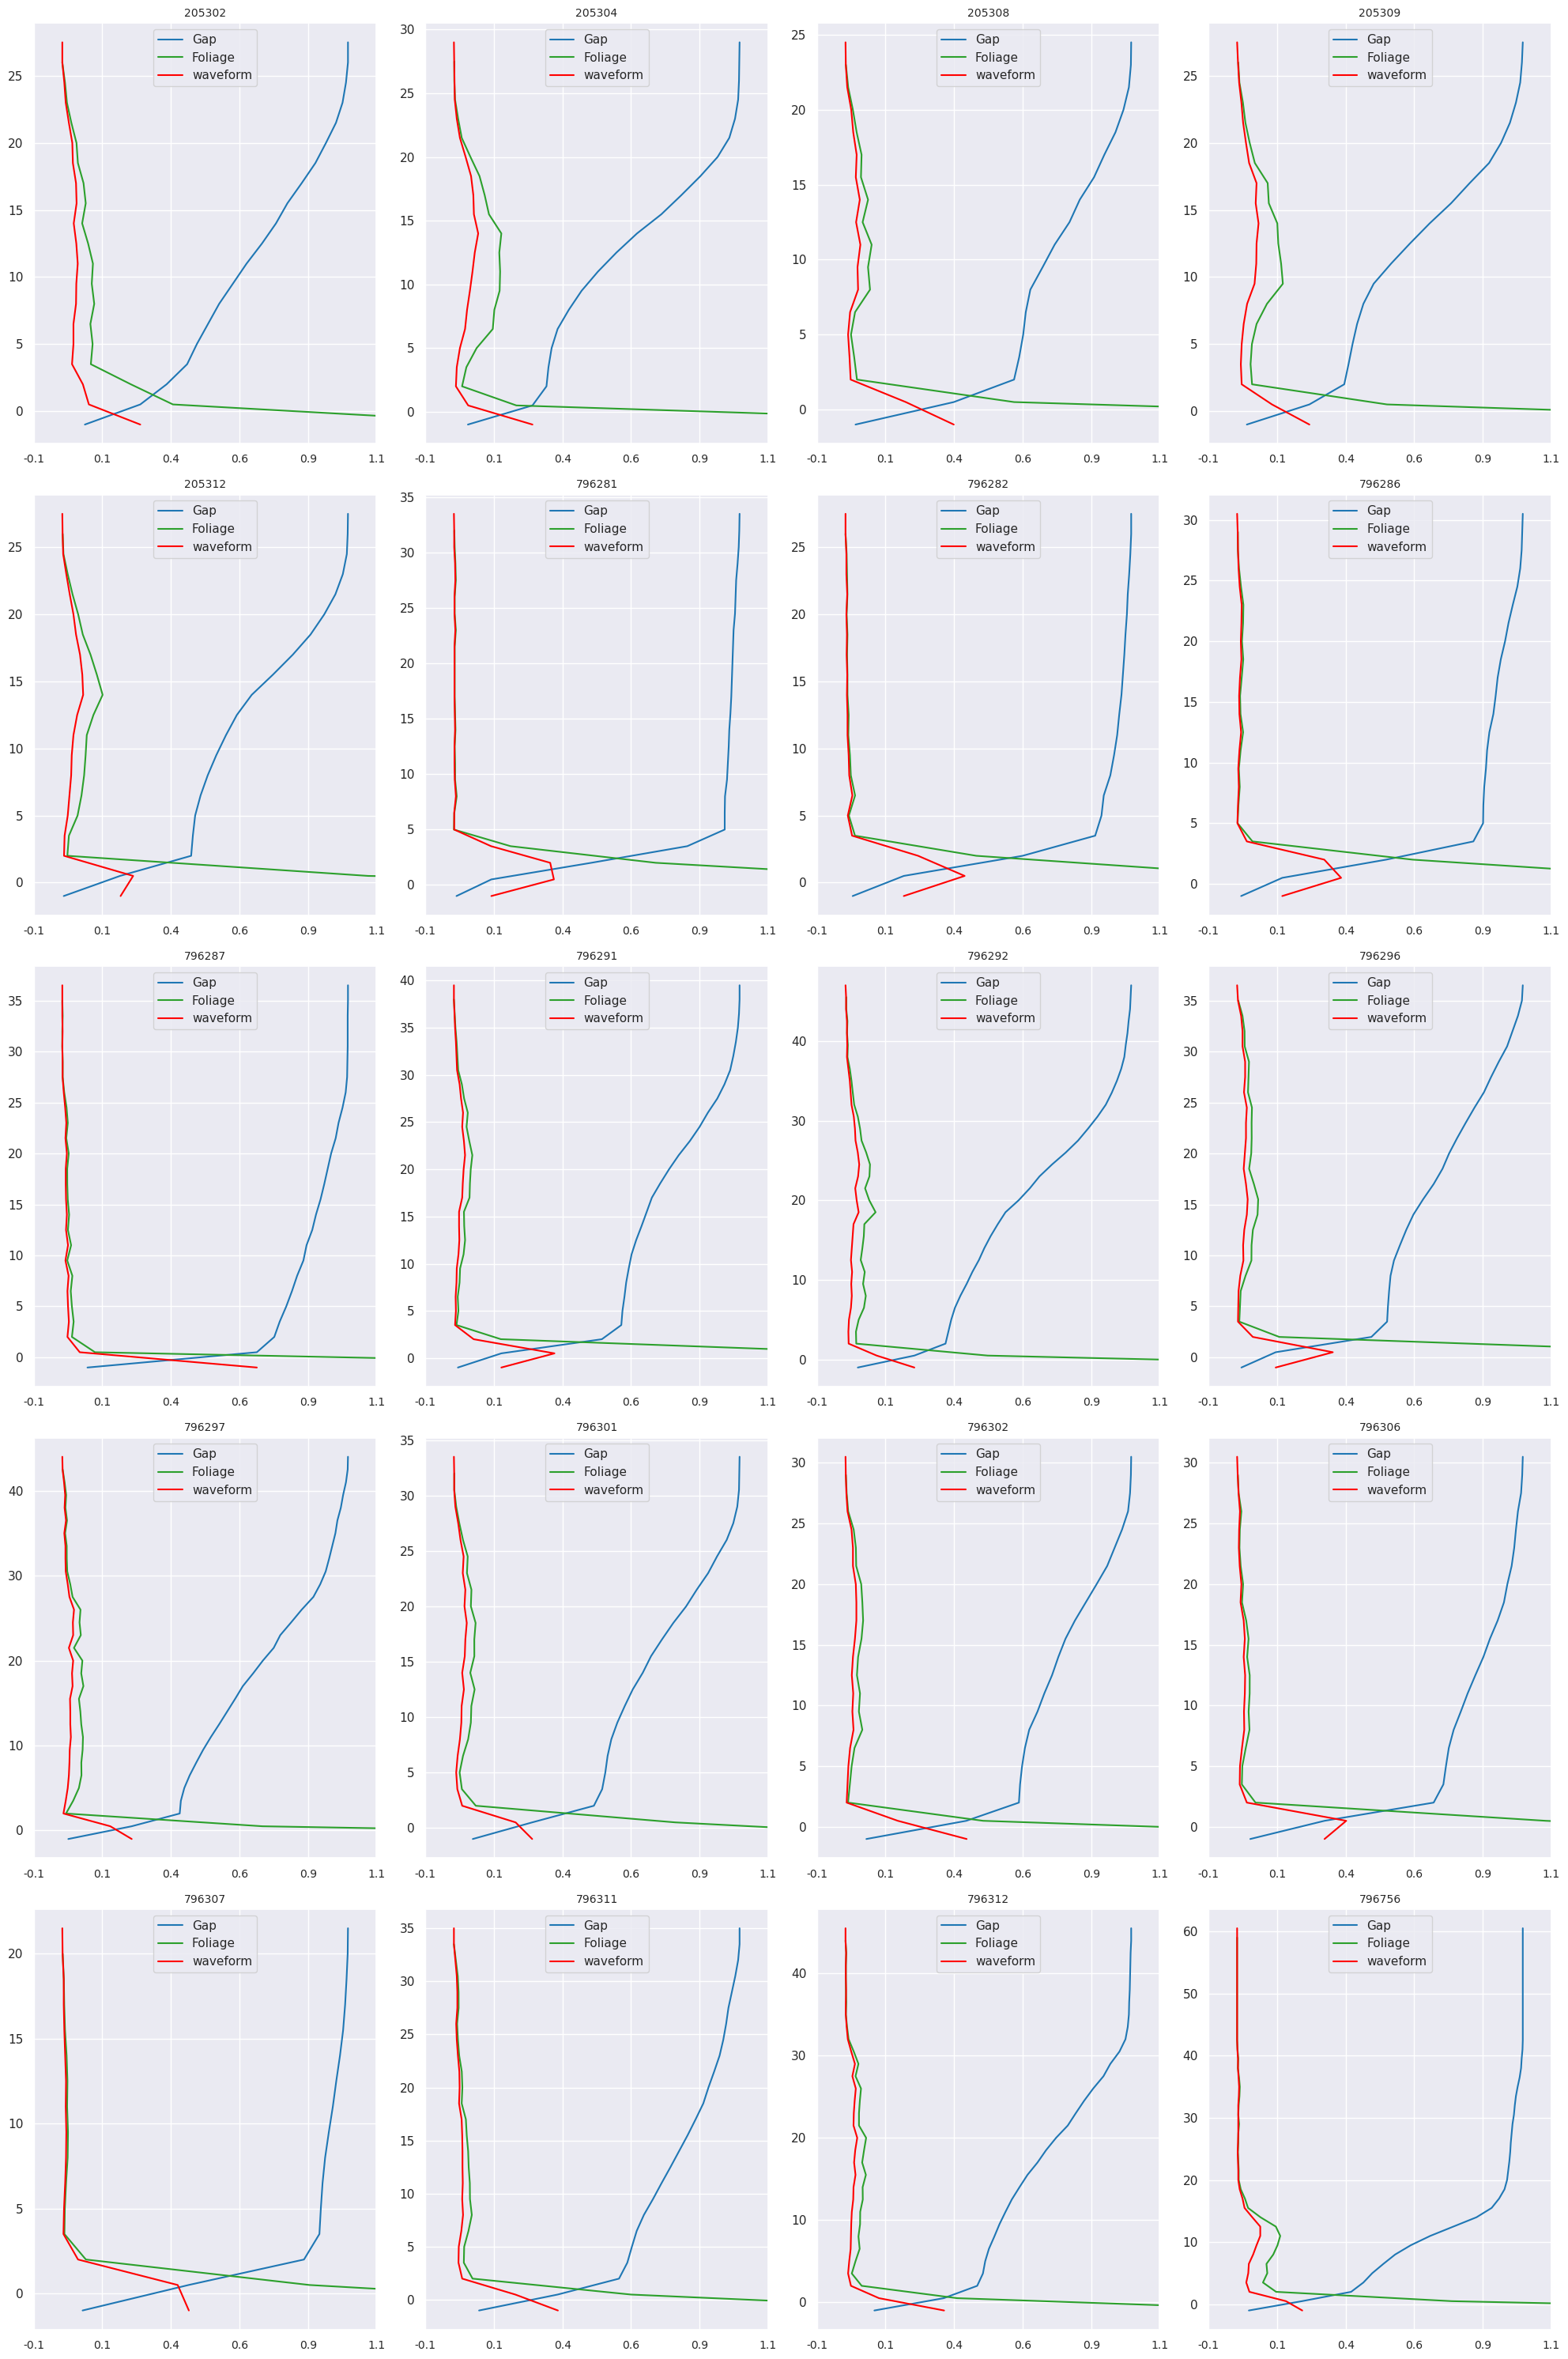

In [13]:
plot_segment(TEAK_site)

In [57]:
plot_smfp_at_icesat(WREF_site, WREF_crs)

Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/0_19_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/20_39_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/40_59_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/60_79_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/80_99_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/100_119_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/120_139_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/140_159_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF/160_179_gap_fol_icesat2.png
Length of Pgap_list: 786
Saving to: /data/shared/src/allen/icesat/figs/WREF

In [41]:
plot_smfp_at_icesat(BONA_10km_site, BONA_crs)

Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_10km/160_179_gap_fol_icesat2.png
Length of Pgap_list: 

In [42]:
plot_smfp_at_icesat(BONA_site, BONA_crs)

Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/0_19_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/20_39_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/40_59_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/60_79_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/80_99_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/100_119_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/120_139_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/140_159_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA/160_179_gap_fol_icesat2.png
Length of Pgap_list: 696
Saving to: /data/shared/src/allen/icesat/figs/BONA

In [43]:
plot_smfp_at_icesat(BONA_50km_site, BONA_crs)

Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_50km/160_179_gap_fol_icesat2.png
Length of Pgap_list: 

In [44]:
plot_smfp_at_icesat(BONA_100km_site, BONA_crs)

Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1050
Saving to: /data/shared/src/allen/icesat/figs/BONA_100km/160_179_gap_fol_icesat2.png
Length of Pg

In [45]:
plot_smfp_at_icesat(DEJU_10km_site, DEJU_crs)

Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_10km/160_179_gap_fol_icesat2.png
Length of Pgap_list: 

In [46]:
plot_smfp_at_icesat(DEJU_site, DEJU_crs)

Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/0_19_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/20_39_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/40_59_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/60_79_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/80_99_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/100_119_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/120_139_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/140_159_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU/160_179_gap_fol_icesat2.png
Length of Pgap_list: 746
Saving to: /data/shared/src/allen/icesat/figs/DEJU

In [47]:
plot_smfp_at_icesat(DEJU_50km_site, DEJU_crs)

Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_50km/160_179_gap_fol_icesat2.png
Length of Pgap_list: 

In [48]:
plot_smfp_at_icesat(DEJU_100km_site, DEJU_crs)

Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/0_19_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/20_39_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/40_59_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/60_79_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/80_99_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/100_119_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/120_139_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/140_159_gap_fol_icesat2.png
Length of Pgap_list: 1187
Saving to: /data/shared/src/allen/icesat/figs/DEJU_100km/160_179_gap_fol_icesat2.png
Length of Pg

In [70]:
plot_smfp_at_icesat(BONA_3km_site, BONA_crs)

353
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/0_19_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/20_39_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/40_59_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/60_79_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/80_99_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/100_119_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/120_139_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/140_159_gap_fol_icesat2.png
Length of Pgap_list: 353
Saving to: /data/shared/src/allen/icesat/figs/BONA_segment/160_179_gap_fol_icesat2.png

In [14]:
plot_smfp_at_icesat(BONA_5km_site)

72
Length of Pgap_list: 72
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/gridded/2024_09_12/0_19_gap_fol_icesat2.png
Length of Pgap_list: 72
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/gridded/2024_09_12/20_39_gap_fol_icesat2.png
Length of Pgap_list: 72
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/gridded/2024_09_12/40_59_gap_fol_icesat2.png
Length of Pgap_list: 72
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/gridded/2024_09_12/60_71_gap_fol_icesat2.png


In [10]:
plot_smfp_at_icesat_individual(BONA_5km_site)

Total segments: 72
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362187_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362203_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362204_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362209_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362270_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_362345_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_639193_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5km_20m/individual/2024_09_12/segment_639196_gap_fol_icesat2.png
Saving to: /data/shared/src/allen/icesat/figs/BONA_5k

In [99]:
### This section will combine ortho images of the segments with the foliage profile

BONA_5km_individual_plots = "/data/shared/src/allen/icesat/figs/BONA_5km_20m/individual"
BONA_5km_ortho_png = "/data/shared/rsdata/orthophotos/BONA/clipped_tif/converted_pngs"
BONA_5km_plot_ortho_combined = "/data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined"

def resize_image_to_height(image, target_height):
    """Resize an image to a target height, maintaining aspect ratio."""
    width, height = image.size
    print(width, height)
    ratio = target_height / height
    new_width = int(width * ratio)
    print(target_height, new_width)
    resized_image = image.resize((new_width, target_height), Image.LANCZOS)
    return resized_image

def combine_images_horizontally(img1_path, img2_path, output_path):
    """Combine two images horizontally and save the result."""
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    # Resize img2 to match the height of img1
    img2 = resize_image_to_height(img2, img1.height)
    
    # Calculate new dimensions
    new_width = img1.width + img2.width
    new_height = img1.height
    
    # Create a new image with the combined width
    new_img = Image.new('RGB', (new_width, new_height))
    
    # Paste the images side by side
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (img1.width, 0))
    
    # Save the combined image
    new_img.save(output_path)

def combine_segment_images(segment_dir1, segment_dir2, output_dir):
    """Combine PNG images from two directories based on segment identifiers."""
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Get list of files in the first directory
    files1 = os.listdir(segment_dir1)
    
    # Extract segment identifiers from the filenames in the first directory
    segment_ids1 = {re.search(r'segment_(\d+)_gap_fol_icesat2\.png', f).group(1) for f in files1 if re.search(r'segment_(\d+)_gap_fol_icesat2\.png', f)}
    
    # Iterate over files in the second directory
    for file2 in os.listdir(segment_dir2):
        match = re.search(r'clipped_segment_(\d+)\.0\.shp\.png', file2)
        if match:
            segment_id = match.group(1)
            
            # Check if this segment ID exists in the first directory
            if segment_id in segment_ids1:
                # Paths to the images
                img1_path = os.path.join(segment_dir1, f'segment_{segment_id}_gap_fol_icesat2.png')
                img2_path = os.path.join(segment_dir2, file2)
                
                # Define the output path
                output_path = os.path.join(output_dir, f'combined_segment_{segment_id}.png')
                
                # Combine the images horizontally
                combine_images_horizontally(img1_path, img2_path, output_path)
                print(f"Combined image saved to {output_path}")

In [100]:
combine_segment_images(BONA_5km_individual_plots, BONA_5km_ortho_png, BONA_5km_plot_ortho_combined)

125 218
1200 688
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_639620.png
120 214
1200 672
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362187.png
102 25
1200 4896
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362203.png
137 403
1200 407
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362204.png
121 210
1200 691
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362209.png
121 210
1200 691
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362270.png
124 216
1200 688
Combined image saved to /data/shared/src/allen/icesat/figs/BONA_5km_20m/plot_ortho_combined/combined_segment_362345.png
125 223
1200 672
Combined image saved to 

In [49]:
###########
## SCRATCH
###########

In [50]:
wbt.lidar_idw_interpolation(
    i=os.path.abspath(f"../data/raw/lidar/BONA/NEON_D19_BONA_DP1_476000_7225000_classified_point_cloud_colorized.las"), 
    output=os.path.abspath("../outputlidarsurface.tif"), 
    parameter="elevation", 
    returns="all", 
    resolution=1.0, 
    weight=1.0, 
    radius=2.5
)

NameError: name 'wbt' is not defined